### The following is a test

It shows plots for an exponential decaying 440 Hz sine wave mixed with recorded background noise.

In [23]:
# Helper functions

##### import sys
import wave
from math import *
import numpy
from statistics import mean
import matplotlib.pyplot as plt

fig_ratio = 1/1
fig_scale = 16
def plot_graph(y, name):
    plt.figure(figsize=(fig_ratio*fig_scale, fig_scale))
    plt.title(name)
    plt.plot(y)
    plt.show()

def rms(nums):
    square_nums = [numpy.int64(x)**2 for x in nums]
    return sqrt(mean(square_nums))

def to_db(p_avg):
    P_0 = numpy.iinfo(numpy.int16).max
    if p_avg == 0: # to prevent math errors
        return 20 * log10(1 / P_0)
    return 20 * log10(p_avg / P_0)

def find_rt30(db, chunk_ms):
    peak_index = numpy.argmax(db)
    peak = db[peak_index]
    db_after_peak = numpy.array(db[peak_index:]) # only examine the amplitude decay after the peak
    rt30_index_after_peak = numpy.abs(peak - db_after_peak - 30).argmin()
    return (rt30_index_after_peak + 1) * chunk_ms

def find_rt60(db, chunk_ms):
    return 2 * find_rt30(db, chunk_ms)

def print_results(results_dict):
    for result in results_dict:
        print(f'Recording: {result}, RT60: {results_dict[result]}ms')

In [26]:
# Wave file processing functions

import os

def process_wav_file(filename):
    # open *.wav file
    try:
        clap_wav = wave.open(filename)
    except BaseException as e:
        print(f'Exception opening .wav file: {e}')
        raise
    if clap_wav.getnchannels() != 1:
        raise Exception("Make sure .wav is mono")
    sample_rate = clap_wav.getframerate()

    # read raw samples
    clap_samples = clap_wav.readframes(-1)
    clap_samples = numpy.frombuffer(clap_samples, dtype='int16')
    plot_graph(clap_samples, 'Raw 16-bit .wav Samples')
    
    # split samples into chunks, then take the RMS of each chunk.
    chunk_ms = 8
    chunk_samples = int(sample_rate * (chunk_ms / 1000))
    recalculated_chunk_ms = chunk_ms # TODO
    n_chunks = int(len(clap_samples) / chunk_samples)
    clap_samples = clap_samples[0 : n_chunks*chunk_samples] # truncate to chunk multiple
    chunks = numpy.split(clap_samples, n_chunks)
    
    # get RMS values
    chunk_mean = [rms(chunk) for chunk in chunks]
    plot_graph(chunk_mean, f'RMS Amplitude ({chunk_ms}ms Chunks)')

    # calculate volume dB
    db = [to_db(m) for m in chunk_mean]
    plot_graph(db, 'Volume (dB) vs Time')
    
    # find RT60
    rt60 = find_rt60(db, chunk_ms)
    print(f'RT60: {rt60}ms')
    
    clap_wav.close()
    
    return rt60

def process_all_wav_files(recording_directory):
    results = {}
    
    directory = os.fsencode(recording_directory)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        print(f'====== Processing recording: {filename} ======')
        rt60 = process_wav_file(f'{recording_directory}/{filename}')
        results[filename] = rt60
        print(f'====== Finished processing recording: {filename} ======')
        
    return results

====== Processing recording: a_clap.wav ======


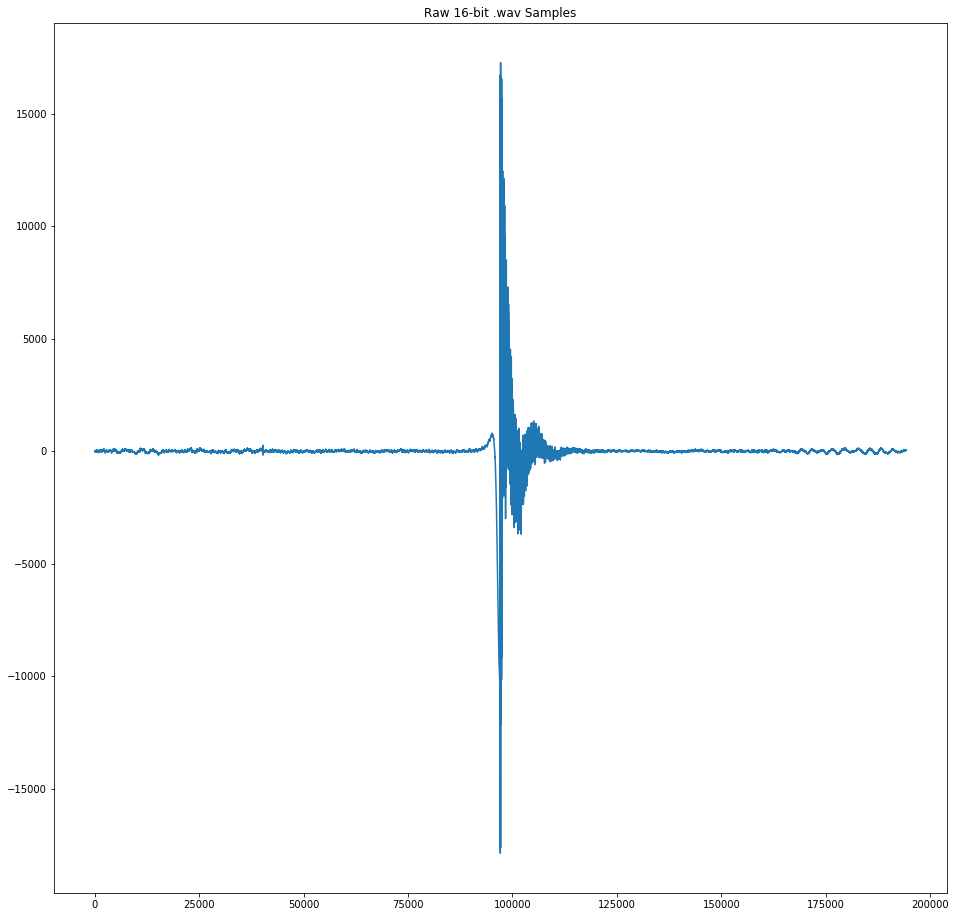

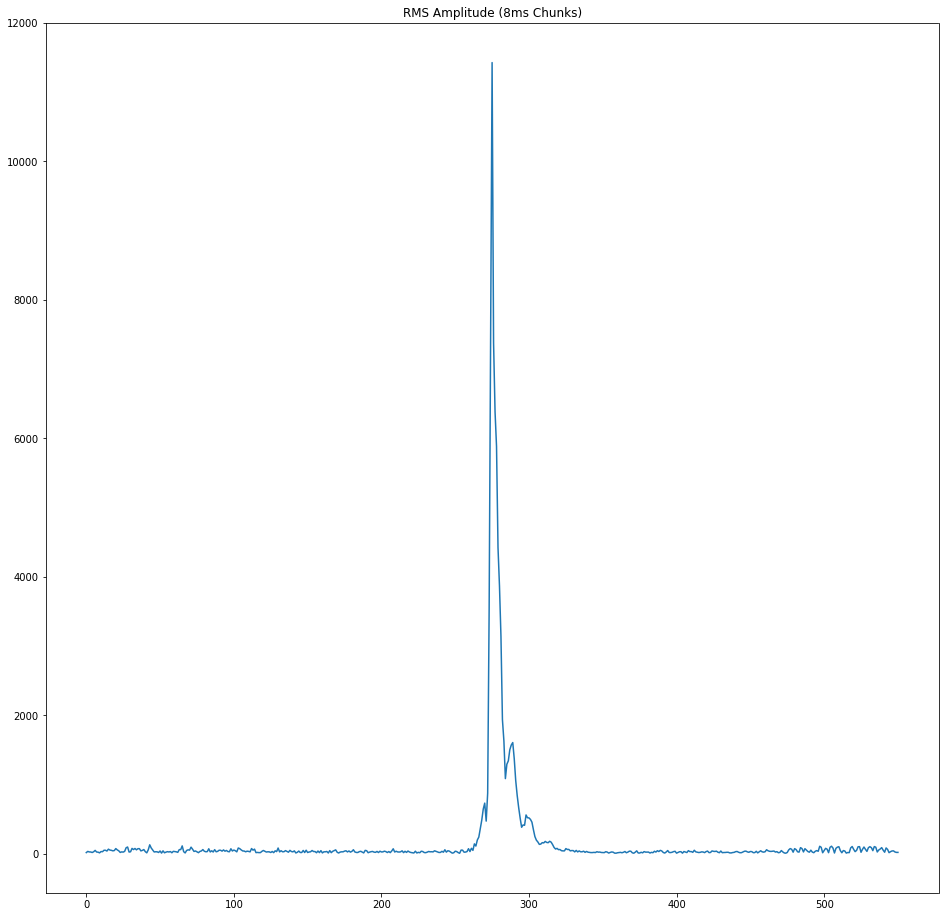

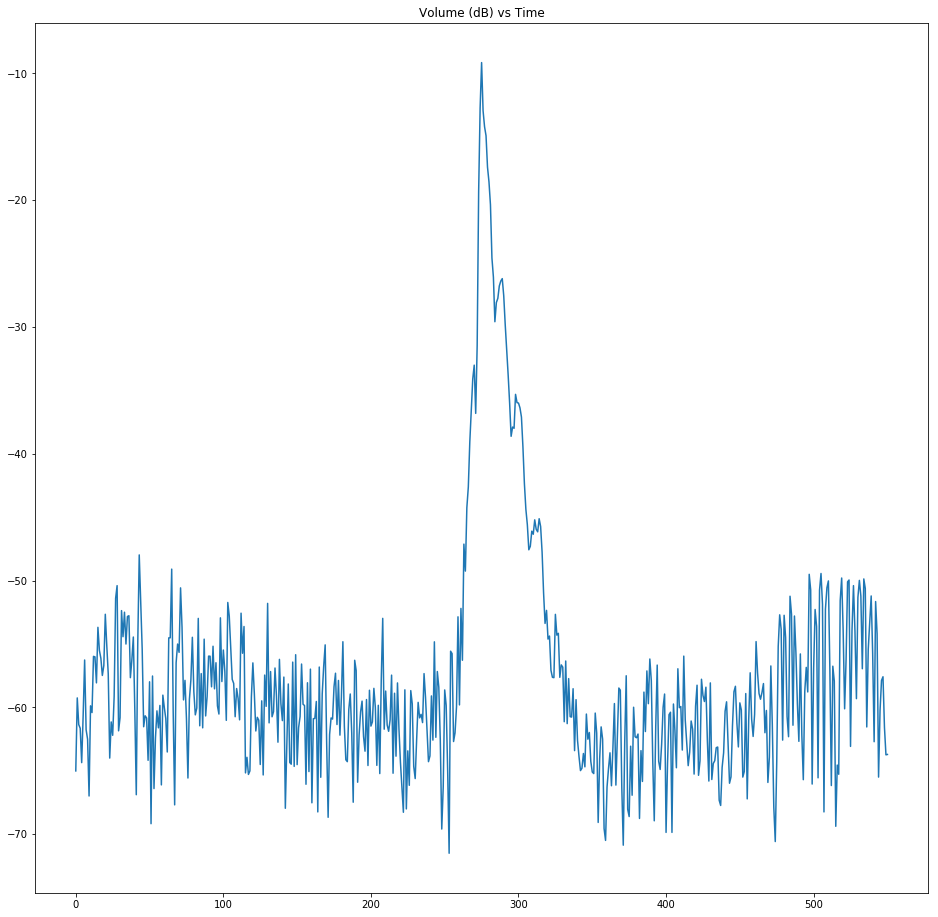

RT60: 464ms
====== Finished processing recording: a_clap.wav ======
====== Processing recording: a_clap_cardboard.wav ======


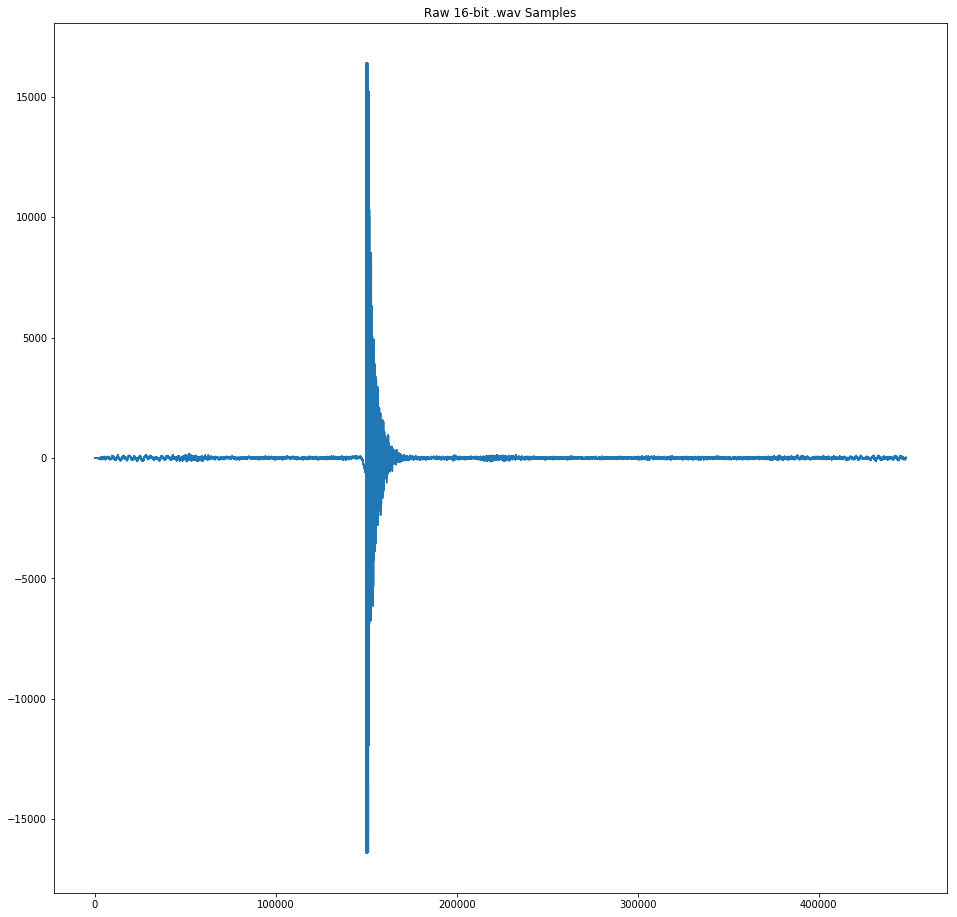

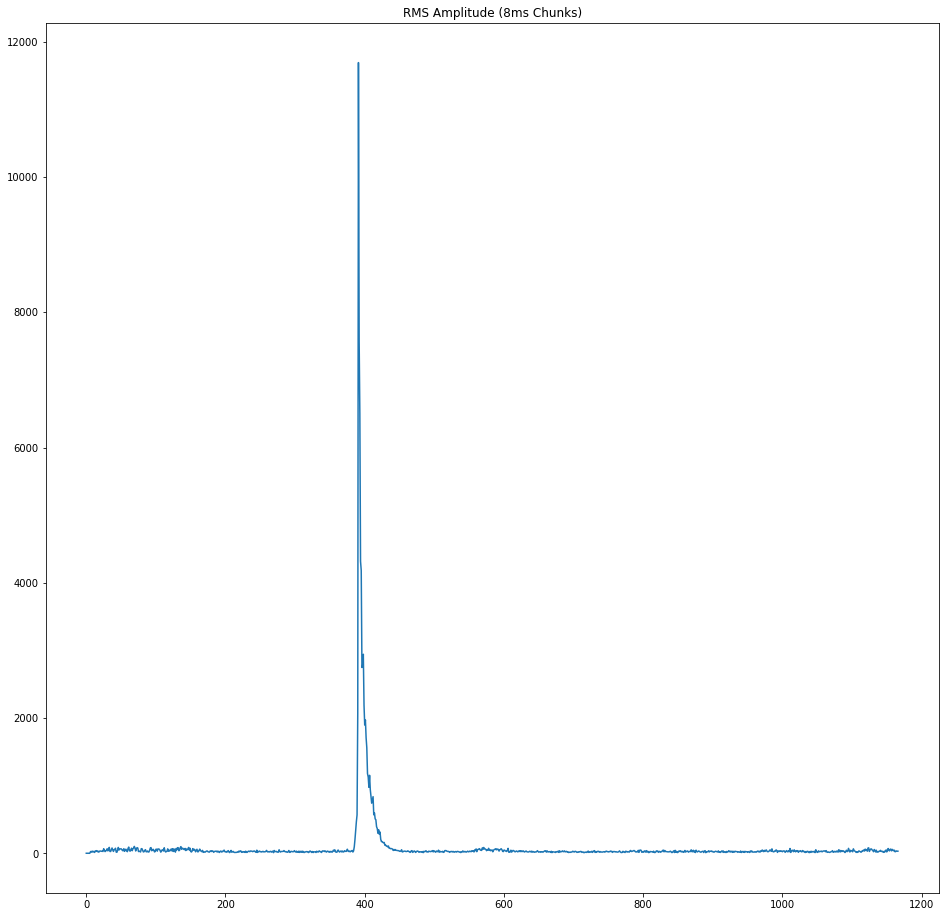

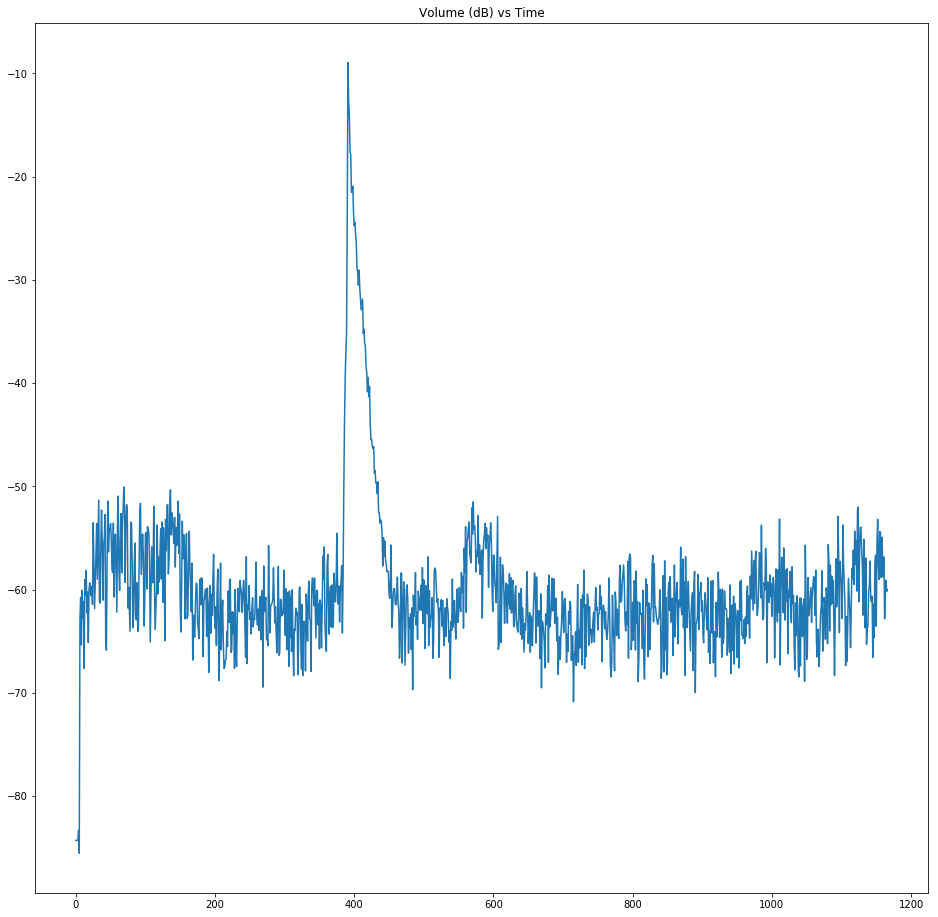

RT60: 448ms
====== Finished processing recording: a_clap_cardboard.wav ======
====== Processing recording: a_clap_cardboard2.wav ======


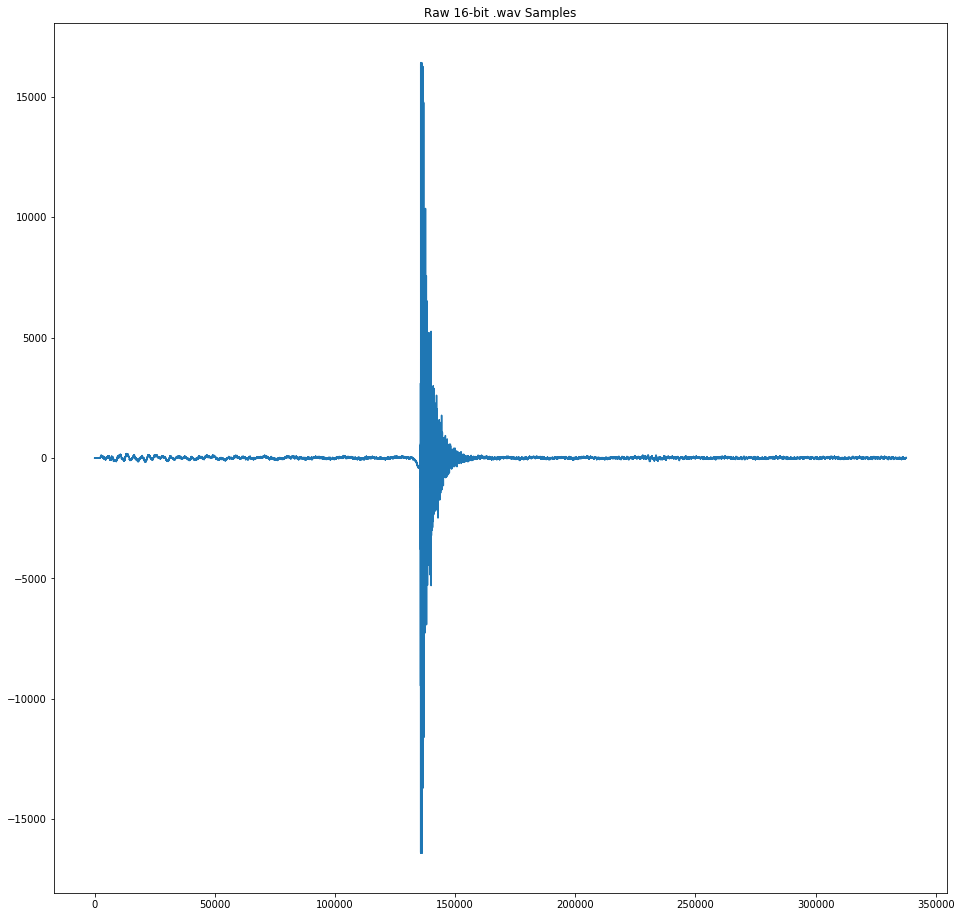

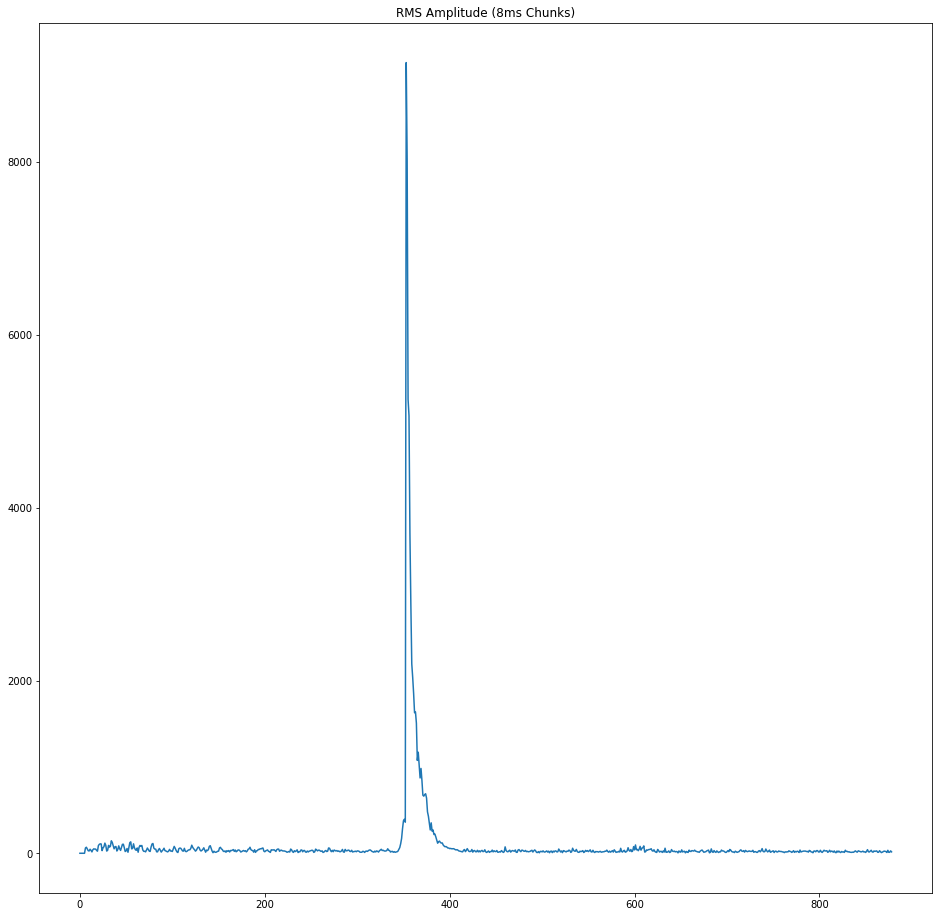

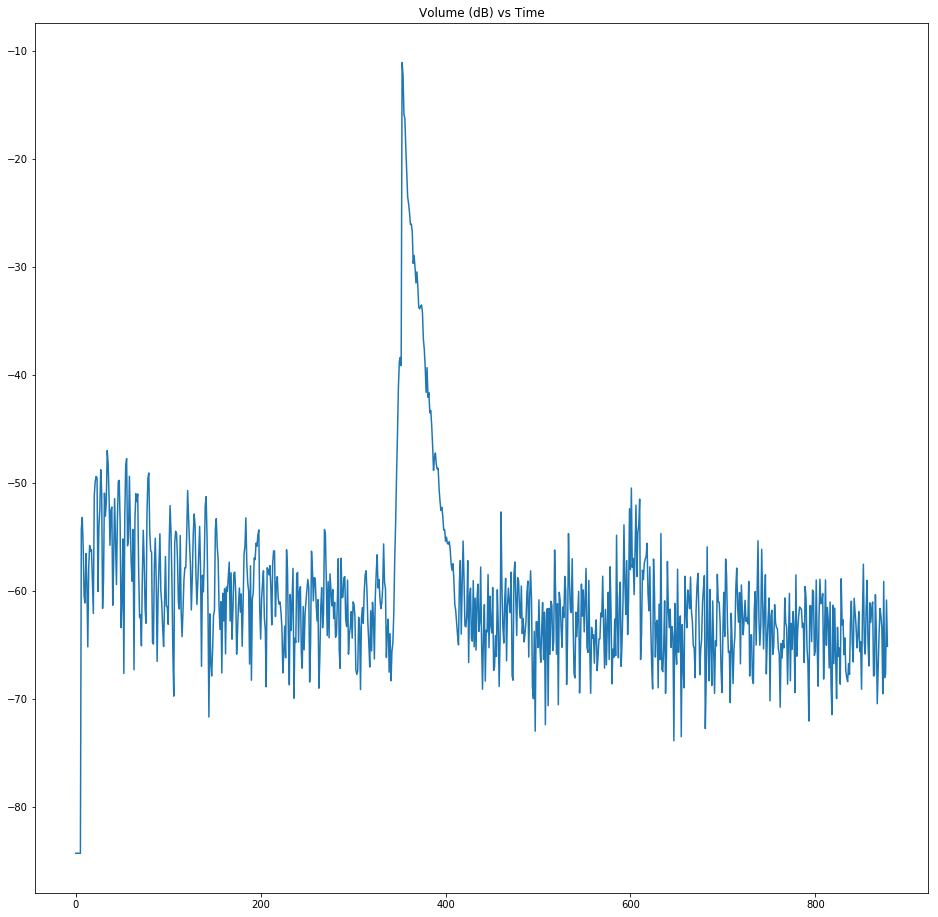

RT60: 432ms
====== Finished processing recording: a_clap_cardboard2.wav ======
====== Processing recording: a_clap_cardboard3.wav ======


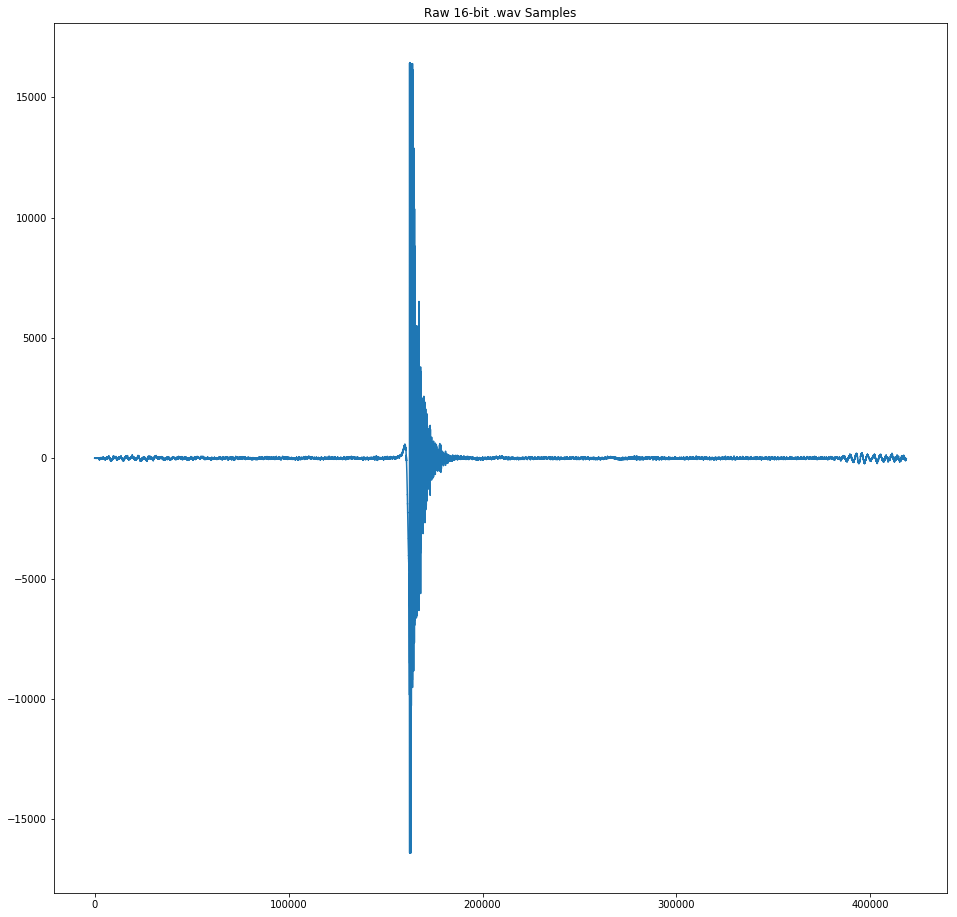

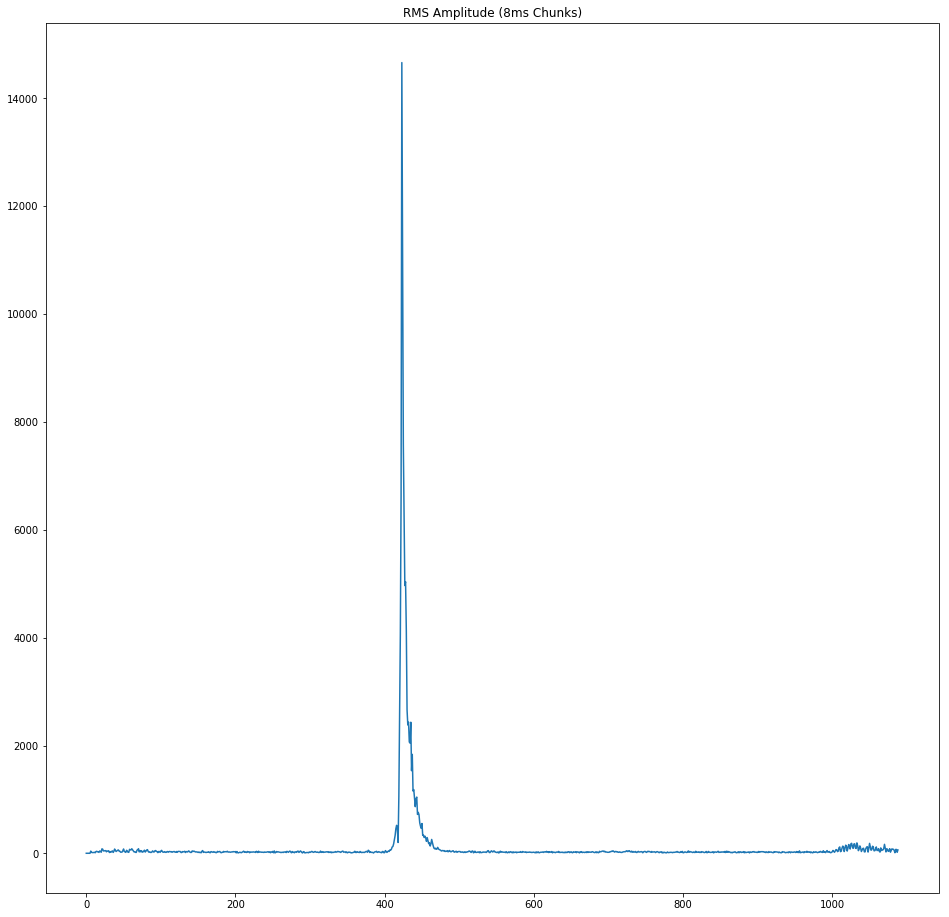

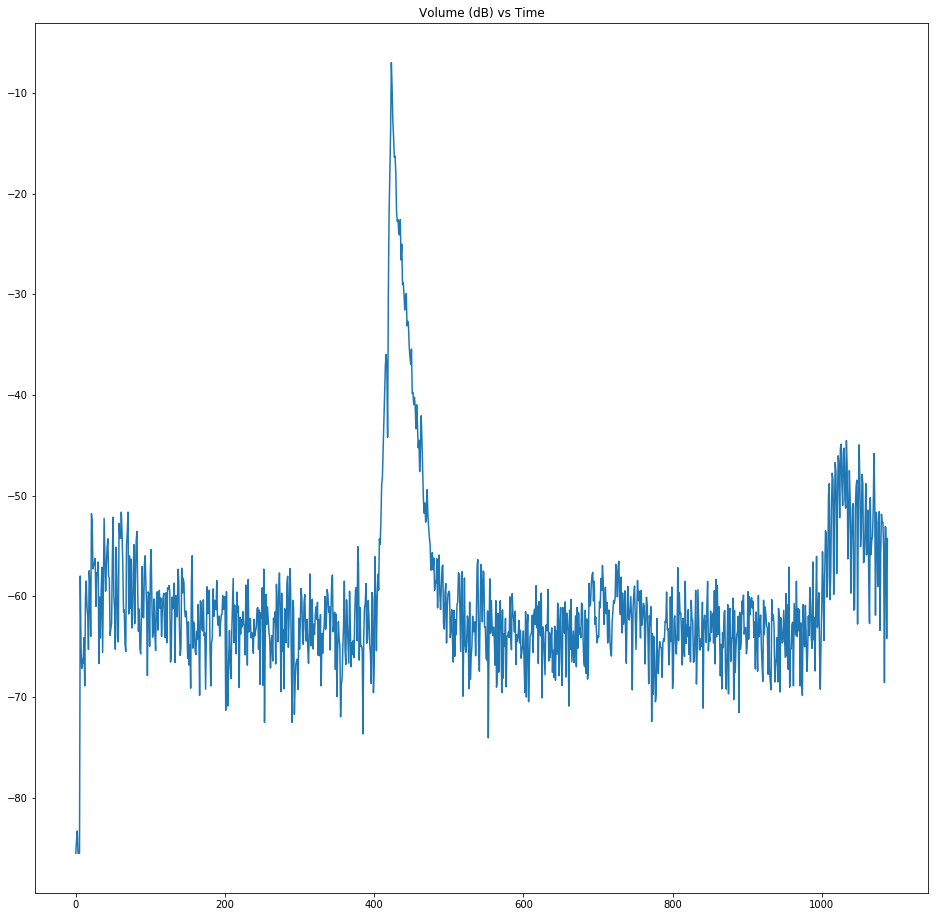

RT60: 432ms
====== Finished processing recording: a_clap_cardboard3.wav ======
====== Processing recording: test.wav ======


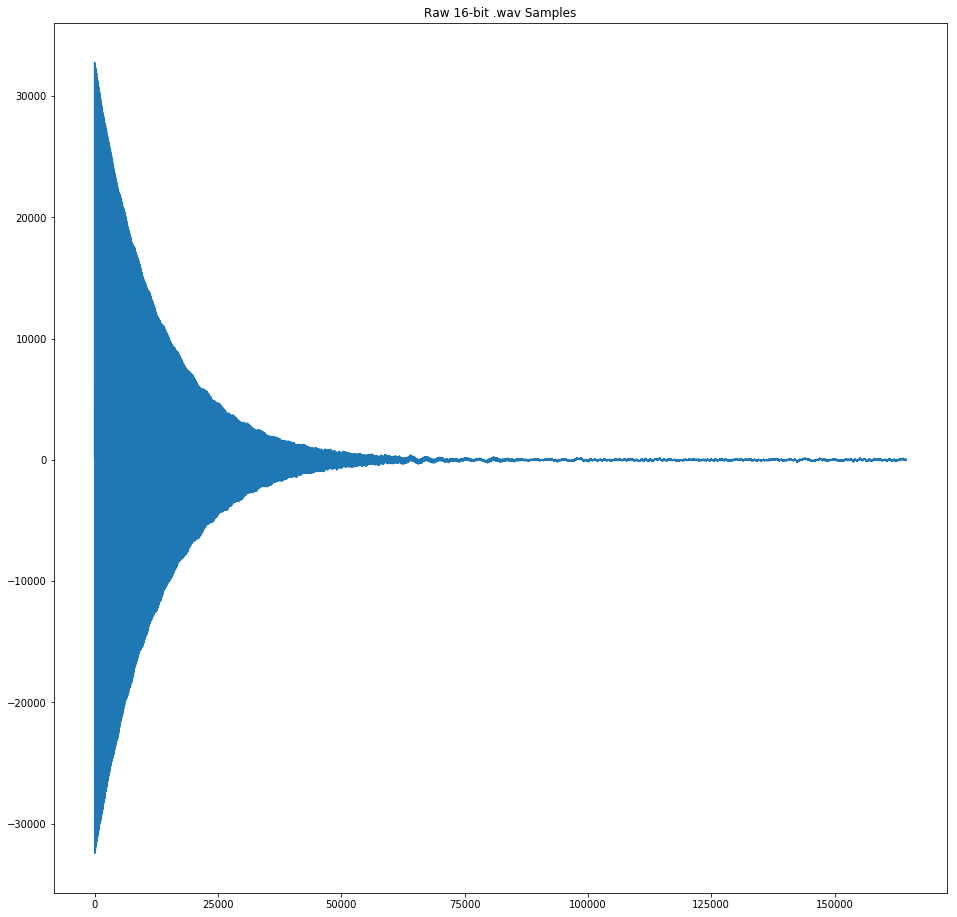

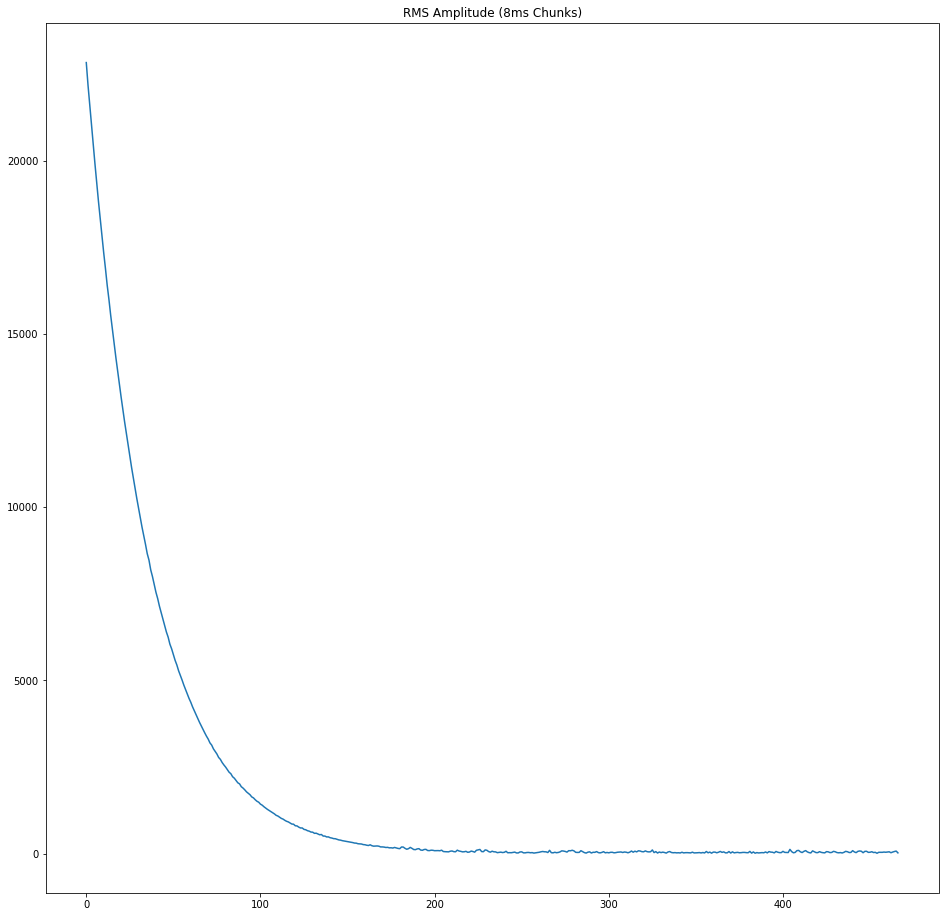

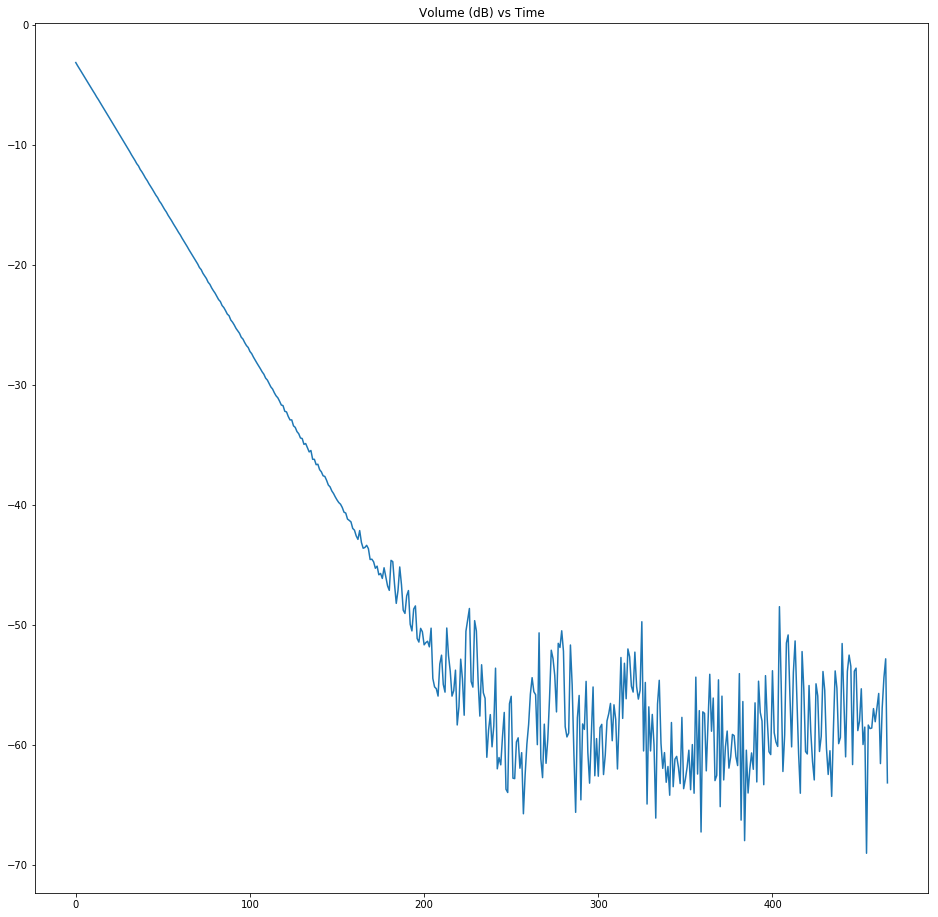

RT60: 2000ms
====== Finished processing recording: test.wav ======
Recording: a_clap.wav, RT60: 464ms
Recording: a_clap_cardboard.wav, RT60: 448ms
Recording: a_clap_cardboard2.wav, RT60: 432ms
Recording: a_clap_cardboard3.wav, RT60: 432ms
Recording: test.wav, RT60: 2000ms


In [27]:
# Process each recorded wave file

recording_directory = 'recordings'
results = process_all_wav_files(recording_directory)
print_results(results)

## Analysis
The RT60 is our main metric for measuring the amount of reverberation an audio signal experiences. It is defined as the time it takes for the audio signal to decay by 60 dB from its peak amplitude. Although louder signals will take longer to completely die out, the RT60 metric is independent on the loudness of the audio source. This is useful in a setting in which the audio source cannot perfectly be reproduced between experiments.

It may be difficult to determine the RT60 by looking at the plot, since the signal may not fall by 60 dB before hitting the noise floor. However, the RT60 can be estimated by determining the RT30 and multiplying by 2.